### Imports

In [4]:
import torch, numpy as np, pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (GPT2Model,GPT2LMHeadModel, 
                          GPT2Config, GPT2Tokenizer,
                         BertConfig, BertTokenizer,
                         BertModel)

### Some Configuration

In [5]:
# Dictionary encoding some pretrained (config, tokenizer, model) options for language model:
language_model_dict = {'bert-base-uncased': [BertConfig, BertTokenizer, BertModel],
             'bert-base-multilingual-cased': [BertConfig, BertTokenizer, BertModel],
              'gpt2': [GPT2Config, GPT2Tokenizer, GPT2LMHeadModel],
              'gpt2-xl': [GPT2Config, GPT2Tokenizer, GPT2Model]
             }

# Dictionary encoding some pretrained (config, tokenizer, model) options:
model_dict = {'bert-base-uncased': [BertConfig, BertTokenizer, BertModel],
             'bert-base-multilingual-cased': [BertConfig, BertTokenizer, BertModel],
              'gpt2': [GPT2Config, GPT2Tokenizer, GPT2LMHeadModel],
              'gpt2-xl': [GPT2Config, GPT2Tokenizer, GPT2LMHeadModel]
             }

# Choose a huggingface pretrained model from the list above, and maybe other options moving forward
config = {"model_name":'gpt2'}

# Choose a pretrained mode
pretrained_model = config["model_name"]

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load a pretrained gpt2 model

In [6]:
# Load tokenizer
tokenizer = model_dict[pretrained_model][1].from_pretrained(pretrained_model)

# Load configuration for bert model; output all hidden states
config = model_dict[pretrained_model][0].from_pretrained(pretrained_model, output_hidden_states=True, use_cache = False, pad_token_id=tokenizer.eos_token_id)

# Load pretrained bert with desired config
model = model_dict[pretrained_model][2].from_pretrained(pretrained_model, config = config)
model.eval()
model = model.to(device)

### Example Language Modeling usage

#### 1) Use model.generate wrapper

In [7]:
# Tokenize some input
tokens = tokenizer.encode("Can you guess what I am going to say", return_tensors='pt')
tokens = tokens.to(device)

In [8]:
# Use the model to generate text beginning with previous text as context, 
# by using top-k decoding within the model.generate wrapper
tokenizer.decode(model.generate(tokens, do_sample=True, 
    max_length=30, top_k = 20)[0],skip_special_tokens=True)

'Can you guess what I am going to say about "Darth Vader\'s Force"? Well, I am not going to try to convince you. I'

#### 2) Greedy decode by hand

In [9]:
# We use the model to generate text using previous text as context,
# by using greedy decoding directly from the LMHead model output:

# Extract final output layer from the LM
with torch.no_grad():
    # All outputs from the Language model
    outputs = model(tokens)
    # The logits output for each of the input tokens:
    predictions = outputs[0]

This ``predictions`` output gives a score for each element of the vocab, for each of the input tokens. This is documented in the return statement of transformers.GPT2LMHeadModel, as described here: https://huggingface.co/transformers/model_doc/gpt2.html#gpt2lmheadmodel . Our ``predictions`` is the returned ``logits`` in the documentation.

In [10]:
# Check the shape to be sure:
# Shape = (batch_size, num_tokens, vocab_size)
predictions.shape

torch.Size([1, 9, 50257])

In [11]:
# Greedily generate the next word by finding the highest scoring vocab
# item for the last token in the input.
predicted_index = torch.argmax(predictions[0, -1, :]).reshape(1,1)
predicted_text = tokenizer.decode(torch.cat((tokens,predicted_index), dim =1).reshape(-1))
predicted_text

'Can you guess what I am going to say?'

### Extracting Token Embedding Representations from LM

Let's now chop off the head of this model, and extract the last hidden state as a sort of high level embedding. Note that by virture of the pretrained model itself, we'll get an embedding per input token in doing this, and we will need to come up with out our own determination of how to associate a single embedding to a sentence. We'll also investigate the effect of negating sentences in two ways:
 
1.  Studying the embeddings themselves, by e.g clustering, studying norm distributions, angle distributions, etc.
2.  Considering the differences of the word embeddings associated to (clause, negation) pairs, and then looking at the distribution of sentiments/clauses/phrases occurring when those differences are decoded by the LM head.

### Comparing Positive and Negative Embeddings

In [12]:
# A statement and one possible negation.
statement = 'This book is bad.'
negation = 'This book is good.'

In [13]:
def extract_hidden_output(text, model = model, tokenizer = tokenizer, layer_num = -1,
                         aggregation = 'average', elt_index = None):
    
    if aggregation == 'average' or aggregation == 'elt':
        # tokenize the input
        tokens = tokenizer.encode(text, return_tensors = 'pt')
        tokens = tokens.to(device)
        
        with torch.no_grad():
            # All outputs from the Language model
            outputs = model(tokens)
            # All hidden states
            hidden_states = outputs[1]
            # Hidden state from layer layer_num
            layer = hidden_states[layer_num]
            layer = torch.squeeze(layer)
            
            # Average the embeddings for each token, and return
            if aggregation == 'average':
                if len(layer.shape) > 1:
                    averaged_layer = torch.mean(layer, dim = 0)
                    return averaged_layer
                else:
                    return layer
                
            if aggregation == 'elt':
                assert elt_index is not None, 'Please specify an element index'
                if len(layer.shape) > 1:
                    last_elt = layer[-1]
                    return last_elt
                else:
                    return layer
        
        
    # Return the embeddings for each token
    if aggregation == 'none':
        tokens = tokenizer.encode(
            text, 
            return_tensors = 'pt'
            #,max_length=max_length,
            #pad_to_max_length=True
        )
        tokens = tokens.to(device)
        '''
        TODO: Return all token embeddings, so can study each individually. For any batch processing,
        this may require different sentiments have the same number of tokens (depending on implemenation), 
        so we may want to set a max length for sentences and pad.
        '''
        pass
    

Let's compute the cosine of the angle between the last layer embeddings associated to the statement and it's negation above:

In [14]:
def compute_cosine(statement1, statement2, aggregation, elt_index = None):
    statement1_vec = extract_hidden_output(statement1, aggregation = aggregation, elt_index = elt_index)
    statement2_vec = extract_hidden_output(statement2, aggregation = aggregation, elt_index = elt_index)
    cosine = torch.dot(statement1_vec, statement2_vec)/(torch.norm(statement1_vec)*torch.norm(statement2_vec))
    return cosine


compute_cosine(statement, negation, aggregation = 'average')

tensor(0.9998, device='cuda:0')

This small angle for a negation is a bit confusing. I suppose this reflects that angle has little to do with similarity in these sorts of transformer models, which in and of itself is interesting, given that it seems common for people to compute pairwise cosines on hidden states as if that represents similarity. Maybe a better interpretation here is that good and bad have similar angles because they are very likely to occur in similar contexts, and this model was probably trained on MLM. For example, ('turtle', 'bad') have a larger angle between them than either ('good', 'bad') or ('good', 'lovely'), which makes sense in the latter interpretation above.


Or, perhaps the way to construct the sentence vector in the LM head of GPT2 is not the one implemented here, the correct one actually results in a larger angle, and this example is completely inaccurate!

### Load Stanford real-life contradictions dataset

In [15]:
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Downloaded 'real-life contradictions' dataset from https://nlp.stanford.edu/projects/contradiction/
tree = ET.parse('data/real_contradiction.xml')
root = tree.getroot()

In [16]:
# Extract contradiction pairs from the XML
pairs = []
for child in root:
    pair =[]
    attrib = child.attrib
    if (attrib['contradiction'] =='YES') & \
    ((attrib['type'] == 'lexical') | (attrib['type'] == 'negation')):
        for statement in child:
            pair.append(statement.text)
    pairs.append(pair)
    
# Remove empty rows
pairs = [pair for pair in pairs if len(pair)>0]

pairs = pd.DataFrame(pairs, columns = ["statement","negation"])

In [17]:
pairs.head(10)

,statement,negation
0,Tariq Aziz was not considered a member of Sadd...,Tariq Aziz was in Saddam's inner circle.
1,Tariq Aziz kept outside the closed circle of S...,Tariq Aziz was in Saddam's inner circle.
2,Tariq Aziz was not one of the most powerful fi...,Tariq Aziz was prominent in the regime.
3,Tariq Aziz retained influence.,Aziz had virtually no power.
4,"No one has been arrested in the case.""",Collin Finnerty was arrested on charges of sex...
5,No one has been arrested in the case.,Two sophomore Duke lacrosse players were arres...
6,Zarqawi did in fact survive the airstrike.,An airstrike ended al-Zarqawi's life.
7,The African Union's mandate in Darfur is to mo...,The African Union will have to enforce the pea...
8,The National Security Agency carries out elect...,The eavesdropping network of the agency [NSA] ...
9,Sudan will grant permission for United Nations...,Sudan is as adamant as ever that it will never...


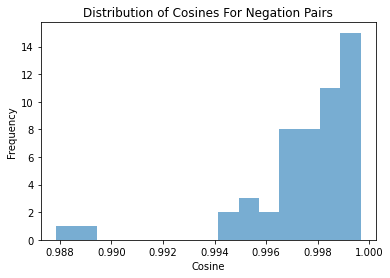

In [24]:
# Store all cosines
cosines = []
for (statement, negation) in zip(pairs.statement.values, pairs.negation.values):
    cosines.append(compute_cosine(statement, negation, aggregation = 'average'))
    
# Plot distribution of cosines among these pairs
fig, ax = plt.subplots()
plt.hist(torch.stack(cosines).cpu(), bins = 15, alpha = .6)
ax.set_title('Distribution of Cosines For Negation Pairs')
ax.set_xlabel("Cosine")
ax.set_ylabel("Frequency")
plt.show()

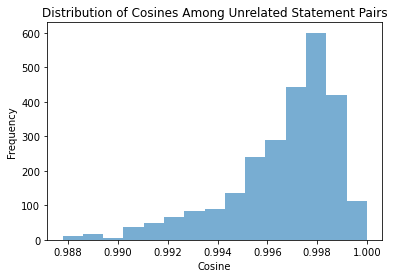

In [29]:
# Store all cosines
cosines = []
for statement1 in pairs.statement.values:
    for statement2 in pairs.statement.values:
        cosines.append(compute_cosine(statement1, statement2, aggregation = 'average'))
    
# Plot distribution of cosines among all statement pairs
fig, ax = plt.subplots()
plt.hist(torch.stack(cosines).cpu(), bins = 15, alpha = .6)
ax.set_title('Distribution of Cosines Among Unrelated Statement Pairs')
ax.set_xlabel("Cosine")
ax.set_ylabel("Frequency")
plt.show()

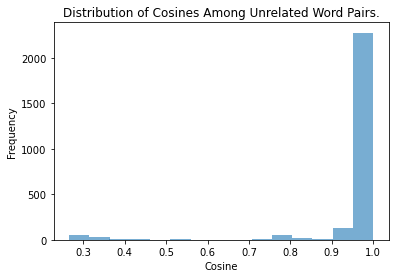

In [30]:
# Store all cosines
cosines = []
for statement1 in pairs.statement.values:
    for statement2 in pairs.statement.values:
        cosines.append(compute_cosine(statement1, statement2, aggregation = 'elt', elt_index = -3))
    
# Plot distribution of cosines among all pairs of last words in the statements
fig, ax = plt.subplots()
plt.hist(torch.stack(cosines).cpu(), bins = 15, alpha = .6)
ax.set_title('Distribution of Cosines Among Unrelated Word Pairs.')
ax.set_xlabel("Cosine")
ax.set_ylabel("Frequency")
plt.show()

There is some bug in the implementation of this cosine calculation, or my understanding; not sure why the cosines are only occurring in such a limited range for all sentence pairs, and even all word pairs in the data. 

### To do:
1.  Determine if there is a bug in the cosine calculation above. The fact that the angles between all pairs of sentences (even those not related by negation) is so small makes me think I didn't compute what I intended to, but I don't yet see the bug. Perhaps this is just an artifact of producing the sentence vectors via averaging token vectors, but I did a small investigation of the angles between pairs of token vectors and got similar results. 
2.  Determine how HF GPT2 implementation constructs sentence embeddings from token embeddings.
3.  Reproduce analogous notebook for Bert, which should be straightforward aside from a few differences in the method  used to produce sentence embeddings.